# Practice Fusion (fast.ai) Language Model and Hypothyroid Classifier

*   Takes in Practice Fusion diagnosis and lab text and creates a language model
*   Builds a classifier on top of the (transfer learned) LM.  
Written by Rose Glavin. Feb 18th 2021



INITIAL SETUP 

In [ ]:
from google.colab import auth
auth.authenticate_user()
project_id = 'hashi-nlp'
!gcloud config set project {project_id}
bucket_name = 'roseglavinhashi'

TASK = 'LanguageModel' #@param {type:"string"}

TASK_DATA_DIR =  TASK
print('***** Task data directory: {} *****'.format(TASK_DATA_DIR))
!mkdir -p $TASK_DATA_DIR
!ls $TASK_DATA_DIR

BUCKET = 'roseglavinhashi' #@param {type:"string"}

OUTPUT_DIR = 'gs://{}/models/{}'.format(BUCKET, TASK)
!mkdir -p  OUTPUT_DIR 
print('***** Model output directory: {} *****'.format(OUTPUT_DIR))


import bs4 as bs
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os as matplotlib
import requests as requests
import csv


Updated property [core/project].
***** Task data directory: LanguageModel *****
***** Model output directory: gs://roseglavinhashi/models/LanguageModel *****


In [ ]:
!gsutil -m cp  gs://roseglavinhashi/Dtext.csv . 
!gsutil -m cp  gs://roseglavinhashi/Ltext.csv . 
!gsutil -m cp  gs://roseglavinhashi/Mtext.csv . 

!gsutil -m cp  gs://roseglavinhashi/PFModelInHypo.csv .
!gsutil -m cp  gs://roseglavinhashi/PFModelInOmitHypo.csv .
!gsutil -m cp  gs://roseglavinhashi/TestInHypo.csv .
!gsutil -m cp  gs://roseglavinhashi/TestInOmitHypo.csv .

Copying gs://roseglavinhashi/Dtext.csv...
- [1/1 files][  5.7 MiB/  5.7 MiB] 100% Done                                    
Operation completed over 1 objects/5.7 MiB.                                      
Copying gs://roseglavinhashi/Ltext.csv...
/ [1/1 files][630.2 KiB/630.2 KiB] 100% Done                                    
Operation completed over 1 objects/630.2 KiB.                                    
Copying gs://roseglavinhashi/Mtext.csv...
/ [1/1 files][  2.3 MiB/  2.3 MiB] 100% Done                                    
Operation completed over 1 objects/2.3 MiB.                                      
Copying gs://roseglavinhashi/PFModelInHypo.csv...
/ [1/1 files][  1.2 MiB/  1.2 MiB] 100% Done                                    
Operation completed over 1 objects/1.2 MiB.                                      
Copying gs://roseglavinhashi/PFModelInOmitHypo.csv...
/ [1/1 files][  1.1 MiB/  1.1 MiB] 100% Done                                    
Operation completed over 1 objects/1.

In [ ]:
!ls


adc.json       Ltext.csv   PFModelInHypo.csv	  TestInHypo.csv
Dtext.csv      Mtext.csv   PFModelInOmitHypo.csv  TestInOmitHypo.csv
LanguageModel  OUTPUT_DIR  sample_data


In [ ]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

In [ ]:
import fastai
from fastai import * 
from fastai.text import *
from fastai.datasets import URLs

Add all the diagnosis descriptions and lab results to train the LM
It contains a row for each patient with either all of the diagnosis description text or the Lab description text (HL7Text). Will be shuffled before batched.

In [ ]:
diagdf = pd.read_csv('Dtext.csv')
labsdf = pd.read_csv('Ltext.csv')
df = pd.concat ([diagdf,labsdf])
f=open("medtxt.csv",mode='w', newline='')
df.to_csv(f, encoding='utf-8', index=False)


In [ ]:
df

,Unnamed: 0,MedicalText
0,1,"Fracture of calcaneus, closed"
1,2,Headache
2,3,"Acute sinusitis, unspecified"
3,4,Routine gynecological examination
4,5,"Epilepsy, unspecified, without mention of intr..."
...,...,...
29009,29010,Sex Hormone Binding Globulin
29010,29011,Sex Hormone Binding Globulin
29011,29012,Sex Hormone Binding Globulin
29012,29013,"T3, Free"


In [ ]:
path = %pwd
path

'/content'

### Tokenization

In [ ]:
data = TextLMDataBunch.from_csv(path, 'medtxt.csv')
data.show_batch()

/usr/local/lib/python3.6/dist-packages/fastai/core.py:302: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return np.array(a, dtype=dtype, **kwargs)


/usr/local/lib/python3.6/dist-packages/fastai/text/data.py:339: UserWarning: This overload of nonzero is deprecated:
	nonzero()
Consider using one of the following signatures instead:
	nonzero(*, bool as_tuple) (Triggered internally at  /pytorch/torch/csrc/utils/python_arg_parser.cpp:882.)
  idx_min = (t != self.pad_idx).nonzero().min()


idx,text
0,"xxbos xxmaj urinary tract infection , site not specified xxbos xxmaj hypertrophy ( benign ) of prostate without urinary obstruction and other lower urinary tract symptoms ( xxup luts ) xxbos xxmaj neutrophils xxbos xxmaj other acne xxbos xxmaj potassium xxbos xxmaj excessive or frequent menstruation xxbos xxup wbc xxbos xxmaj insomnia , unspecified xxbos xxmaj other and unspecified hyperlipidemia xxbos xxmaj chronic kidney disease , xxmaj stage xxup iii"
1,"of anticoagulants xxbos xxmaj routine infant or child health check xxbos xxmaj pure hypercholesterolemia xxbos xxmaj unspecified hypothyroidism xxbos xxmaj esophageal reflux xxbos xxmaj dermatophytosis of the body xxbos xxmaj essential hypertension xxbos xxup wbc xxbos monocytes(absolute ) xxbos xxmaj albumin / xxmaj globulin xxbos xxmaj degeneration of lumbar or lumbosacral intervertebral disc xxbos xxmaj unspecified disorder of skin and subcutaneous tissue xxbos xxmaj allergic rhinitis , cause unspecified xxbos"
2,"without exacerbation xxbos xxmaj acute cystitis xxbos xxmaj anemia , unspecified xxbos xxmaj polymyalgia rheumatica xxbos xxmaj hemoglobin xxbos xxmaj bilirubin , xxmaj total xxbos xxmaj bilirubin xxbos xxmaj calcifying tendinitis of shoulder xxbos xxmaj senile osteoporosis xxbos xxmaj neutrophils xxbos xxmaj cellulitis and abscess of upper arm and forearm xxbos xxmaj globulin xxbos xxmaj routine general medical examination at a health care facility xxbos xxmaj congestive heart failure ,"
3,"mild mental retardation xxbos xxmaj anxiety state , unspecified xxbos xxmaj orthostatic hypotension xxbos xxmaj mixed hyperlipidemia xxbos xxmaj other abnormal blood chemistry xxbos xxmaj other chest pain xxbos xxmaj allergic rhinitis xxbos xxmaj unspecified functional disorder of stomach xxbos xxmaj neutrophils xxbos xxmaj other abnormal glucose xxbos xxmaj estimated xxup gfr ( egfr ) xxbos xxmaj abnormal loss of weight xxbos xxmaj insect bite , nonvenomous , of hip"
4,"xxmaj insomnia , unspecified xxbos xxmaj other abnormal glucose xxbos xxmaj proteinuria xxbos xxmaj screening for malignant neoplasms of colon xxbos xxmaj dysphonia xxbos xxmaj pityriasis versicolor xxbos xxmaj asthma , unspecified type , with acute exacerbation xxbos xxmaj other specified visual disturbances xxbos xxmaj unspecified hypothyroidism xxbos xxmaj hemoglobin xxbos xxmaj plantar fascial fibromatosis xxbos xxmaj thyroxine xxbos xxmaj need for prophylactic vaccination and inoculation against influenza xxbos xxmaj"


### Numericalization

In [ ]:
data.vocab.itos[:10]

['xxunk',
 'xxpad',
 'xxbos',
 'xxeos',
 'xxfld',
 'xxmaj',
 'xxup',
 'xxrep',
 'xxwrep',
 ',']

In [ ]:
data.train_ds[0][0]

Text [ 2  5 29 17 15]

## Language model

In [ ]:
bs=48

In [ ]:
data.save('data_lm.pkl')

In [ ]:
data_lm = load_data(path, 'data_lm.pkl', bs=bs)

In [ ]:
data_lm.show_batch()

idx,text
0,"xxbos xxmaj urinary tract infection , site not specified xxbos xxmaj hypertrophy ( benign ) of prostate without urinary obstruction and other lower urinary tract symptoms ( xxup luts ) xxbos xxmaj neutrophils xxbos xxmaj other acne xxbos xxmaj potassium xxbos xxmaj excessive or frequent menstruation xxbos xxup wbc xxbos xxmaj insomnia , unspecified xxbos xxmaj other and unspecified hyperlipidemia xxbos xxmaj chronic kidney disease , xxmaj stage xxup iii"
1,"xxbos xxmaj degeneration of lumbar or lumbosacral intervertebral disc xxbos xxmaj chronic sinusitis xxbos xxmaj tonsillitis , acute xxbos xxmaj hematocrit xxbos xxmaj cervicalgia xxbos xxmaj bilirubin xxbos xxmaj other abnormal glucose xxbos xxmaj globulin xxbos xxmaj acute mucoid otitis media xxbos xxmaj mixed hyperlipidemia xxbos xxmaj decubitus ulcer , buttock xxbos xxmaj streptococcal sore throat xxbos xxmaj urobilinogen xxbos xxmaj thrombocytopenia , unspecified xxbos xxmaj headache xxbos xxmaj subjective"
2,"conjunctivitis , unspecified xxbos xxmaj creatinine , xxmaj serum xxbos xxmaj neutrophils - xxmaj absolute xxbos xxmaj malignant neoplasm of prostate xxbos xxmaj pure hypercholesterolemia xxbos xxmaj suppurative and unspecified otitis media xxbos xxmaj gout , unspecified xxbos xxmaj neutrophils ( xxmaj absolute ) xxbos xxmaj hematocrit xxbos xxmaj unspecified chest pain xxbos xxmaj allergic rhinitis , cause unspecified xxbos xxmaj acute upper respiratory infections of unspecified site xxbos xxmaj"
3,"xxmaj insomnia , unspecified xxbos xxmaj other abnormal glucose xxbos xxmaj proteinuria xxbos xxmaj screening for malignant neoplasms of colon xxbos xxmaj dysphonia xxbos xxmaj pityriasis versicolor xxbos xxmaj asthma , unspecified type , with acute exacerbation xxbos xxmaj other specified visual disturbances xxbos xxmaj unspecified hypothyroidism xxbos xxmaj hemoglobin xxbos xxmaj plantar fascial fibromatosis xxbos xxmaj thyroxine xxbos xxmaj need for prophylactic vaccination and inoculation against influenza xxbos xxmaj"
4,"moderate degree xxbos xxmaj abdominal pain , left lower quadrant xxbos xxmaj routine general medical examination at a health care facility xxbos xxmaj shortness of breath xxbos xxmaj other malaise and fatigue xxbos xxmaj malignant neoplasm of colon , unspecified xxbos xxmaj appearance xxbos xxmaj xxunk disorder xxbos xxmaj unspecified essential hypertension xxbos xxmaj carpal tunnel syndrome xxbos xxmaj leukocytopenia , unspecified xxbos xxmaj acute conjunctivitis , unspecified xxbos xxmaj"


We can then put this in a learner object very easily with a model loaded with the pretrained weights. They'll be downloaded the first time you'll execute the following line and stored in `~/.fastai/models/` (or elsewhere if you specified different paths in your config file).

In [ ]:
learn = language_model_learner(data, AWD_LSTM, drop_mult=0.3)

In [ ]:
learn.lr_find()

epoch,train_loss,valid_loss,accuracy,time


LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


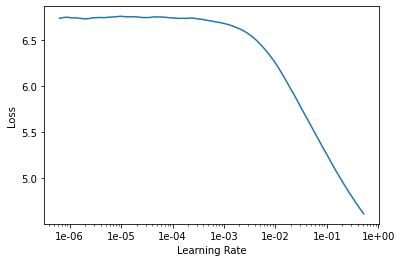

In [ ]:
learn.recorder.plot(skip_end=15)

In [ ]:
learn.fit_one_cycle(1, 1e-2, moms=(0.8,0.7))

epoch,train_loss,valid_loss,accuracy,time
0,1.792426,1.361697,0.732095,18:35


In [ ]:
learn.save('fit_head')

In [ ]:
learn.load('fit_head');

To complete the fine-tuning, we can then unfeeze and launch a new training.

In [ ]:
learn.unfreeze()

THis time change to only train the whole model for 2 epochs

In [ ]:
learn.fit_one_cycle(2, 1e-3, moms=(0.8,0.7))

epoch,train_loss,valid_loss,accuracy,time
0,1.328573,1.230075,0.753632,28:43
1,1.237270,1.195637,0.758455,28:40


In [ ]:
learn.save('fine_tuned')
learn.save_encoder('fine_tuned_enc')

How good is our model? Well let's try to see what it predicts after a few given words.

In [ ]:
learn.load('fine_tuned');

In [ ]:
TEXT = "Pain in the lower leg. Fungal Infection. UTI "
N_WORDS = 20
N_SENTENCES = 2

In [ ]:
print("\n".join(learn.predict(TEXT, N_WORDS, temperature=0.8) for _ in range(N_SENTENCES)))

Pain in the lower leg. Fungal Infection. UTI  : Acute maxillary sinusitis xxbos Encounter for long - term ( current ) use of anticoagulants xxbos Anxiety state , unspecified xxbos Other specified idiopathic peripheral neuropathy xxbos Depressive disorder , NOS xxbos
Pain in the lower leg. Fungal Infection. UTI  WHITE CELL COUNT xxbos Other specified visual disturbances xxbos Appearance xxbos Routine general medical examination at a health care facility xxbos Chloride xxbos Benign essential hypertension xxbos Other and unspecified hyperlipidemia


In [ ]:
TEXT = "essential hypertension   "
print("\n".join(learn.predict(TEXT, N_WORDS, temperature=0.7) for _ in range(N_SENTENCES)))


essential hypertension    xxbos Acute bronchitis xxbos Routine general medical examination at a health care facility xxbos Benign essential hypertension xxbos Triglyceride xxbos Globulin xxbos Dysphagia , unspecified xxbos Hemoglobin xxbos Encounter for long -
essential hypertension    xxbos Unspecified essential hypertension xxbos Carpal tunnel syndrome xxbos COMPLETE BLOOD COUNT xxbos Anxiety state , unspecified xxbos Cough xxbos Coronary atherosclerosis of native coronary artery xxbos Chloride xxbos Prophylactic


In [ ]:
TEXT = "Urinary Tract Infection  lower leg "
print("\n".join(learn.predict(TEXT, N_WORDS, temperature=0.7) for _ in range(N_SENTENCES)))

Urinary Tract Infection  lower leg  xxbos Acute bronchitis xxbos Dermatophytosis of nail xxbos Other specified acquired hypothyroidism xxbos Headache xxbos Acute bronchitis xxbos Unspecified essential hypertension xxbos Meniere 's disease xxbos Globulin xxbos Chloride xxbos
Urinary Tract Infection  lower leg  , not specified xxbos Protein xxbos Other and unspecified hyperlipidemia xxbos Dermatophytosis of foot xxbos Globulin xxbos COPD , NOS xxbos Other colitis xxbos Protein xxbos Vaginitis and vulvovaginitis xxbos


In [ ]:
learn.save_encoder('fine_tuned_enc')

## Classifier

In [ ]:
!gsutil -m cp    gs://roseglavinhashi/PFModelIN.csv .


Copying gs://roseglavinhashi/PFModelIN.csv...
/ [1/1 files][  1.2 MiB/  1.2 MiB] 100% Done                                    
Operation completed over 1 objects/1.2 MiB.                                      


In [ ]:
PFindf = pd.read_csv('PFModelInOmitHypo.csv')
PFindf

,Y_Label,MedicalText
0,1,Pure hypercholesterolemia.Premenstrual tension...
1,0,"Obesity, unspecified"
2,1,"Infertility, female, of unspecified origin.Fla..."
3,0,Diarrhea.Encounter for long-term (current) use...
4,0,"Lumbago.Scoliosis [and kyphoscoliosis], idiopa..."
...,...,...
2059,1,Dysthymic disorder.Mixed hyperlipidemia.Iron d...
2060,1,"Benign essential hypertension.Fever, unspecifi..."
2061,0,"Flatulence, eructation, and gas pain.Abdominal..."
2062,0,Supervision of normal first pregnancy.Group B ...


In [ ]:

data_clas = TextClasDataBunch.from_csv(path, 'PFModelInOmitHypo.csv', vocab=data_lm.train_ds.vocab, bs=bs)

/usr/local/lib/python3.6/dist-packages/fastai/core.py:302: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return np.array(a, dtype=dtype, **kwargs)


/usr/local/lib/python3.6/dist-packages/numpy/core/_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order)
<string>:6: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray


Now, we'll create a new data object that only grabs the labelled data and keeps those labels. Again, this line takes a bit of time.

In [ ]:
data_clas.save('data_clas.pkl')

In [ ]:
data_clas = load_data(path, 'data_clas.pkl', bs=bs)

/usr/local/lib/python3.6/dist-packages/numpy/core/_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order)
<string>:6: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray


In [ ]:
data_clas.show_batch()

/usr/local/lib/python3.6/dist-packages/numpy/core/_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order)
<string>:6: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray


text,target
"xxbos xxmaj urinary tract infection , site not specified . xxmaj decreased libido . xxmaj degeneration of lumbar or lumbosacral intervertebral disc . xxmaj other malaise and fatigue . xxmaj hyposmolality and / or hyponatremia . xxmaj senile osteoporosis . xxmaj degeneration of cervical intervertebral disc . xxmaj cough . xxmaj other malaise and fatigue . xxmaj fever , unspecified . xxmaj acute bronchiolitis due to other infectious organisms .",0
"xxbos xxmaj gout xxunk actinomycotic infection . xxmaj myalgia and myositis , unspecified . xxmaj abdominal pain , epigastric . xxmaj other vitamin xxup b12 deficiency anemia . xxmaj absence of menstruation . xxmaj cough . xxmaj seborrheic dermatitis . xxmaj routine general medical examination at a health care facility . xxmaj nonspecific elevation of levels of transaminase or lactic acid dehydrogenase [ xxunk , unspecified . xxmaj other and",0
"xxbos xxmaj unspecified cerebrovascular disease . xxmaj memory loss xxunk vitamin d deficiency . xxmaj other protein - calorie malnutrition . xxmaj osteoporosis xxunk of lumbar or lumbosacral intervertebral disc . xxmaj pain in joint involving hand . xxmaj degeneration of thoracic or thoracolumbar intervertebral disc . xxmaj other specified gastritis , without mention of hemorrhage . xxmaj iron deficiency anemia secondary to blood loss ( xxunk and myositis ,",1
"xxbos xxmaj nonsuppurative otitis media , not specified as acute or chronic . xxmaj pyrexia of unknown origin . xxmaj other malaise and fatigue . xxmaj irregular menstrual cycle . xxmaj diaper or napkin rash . xxmaj fever , unspecified . xxmaj other postsurgical status . xxmaj cough . xxmaj excessive or frequent menstruation . xxmaj benign essential hypertension . xxmaj acute bronchitis . xxmaj allergic rhinitis , cause unspecified",0
"xxbos xxmaj obesity , unspecified . xxmaj migraine , unspecified , without mention of intractable migraine without mention of status migrainosus . xxmaj acute bronchitis . xxmaj abdominal pain , epigastric . xxmaj acute sinusitis , unspecified . xxmaj tear of medial cartilage or meniscus of knee , current . xxmaj routine gynecological examination . xxmaj acute pharyngitis . xxmaj seborrheic keratosis . xxmaj atypical face pain . xxmaj anxiety",0


We can then create a model to classify EHR Text and load the encoder we saved before.

In [ ]:
learn = text_classifier_learner(data_clas, AWD_LSTM, drop_mult=0.5)
learn.load_encoder('fine_tuned_enc')

RNNLearner(data=TextClasDataBunch;

Train: LabelList (1651 items)
x: TextList
xxbos xxmaj encounter for long - term ( current ) use of other medications . xxmaj arthropathy unspecified , involving hand . xxmaj pure hypercholesterolemia . xxmaj spondylosis of unspecified site xxunk chronic bronchitis . xxmaj unspecified vitamin d deficiency . xxmaj closed fracture of neck of metacarpal xxunk of tympanic membrane , unspecified . xxmaj dermatomyositis . xxmaj closed fracture of lumbar vertebra without mention of spinal cord injury . xxmaj constipation , unspecified . xxmaj malignant neoplasm of prostate,xxbos xxmaj mixed hyperlipidemia . xxmaj malaise and fatigue . xxmaj xxunk problems , not elsewhere classified . xxmaj need for prophylactic vaccination and inoculation against viral hepatitis . xxmaj urinary tract infection , site not specified . xxmaj carpal tunnel syndrome . xxmaj other sleep disturbances . xxmaj other acute otitis externa . xxmaj nonspecific abnormal results of functio

In [ ]:
learn.lr_find()

/usr/local/lib/python3.6/dist-packages/numpy/core/_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order)
<string>:6: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
/usr/local/lib/python3.6/dist-packages/numpy/core/_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return ar

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


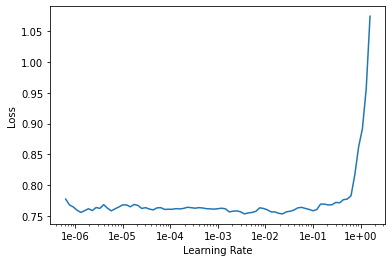

In [ ]:
learn.recorder.plot()

In [ ]:
learn.fit_one_cycle(1, 2e-2, moms=(0.8,0.7))

epoch,train_loss,valid_loss,accuracy,time
0,0.726531,0.683267,0.556901,04:17


/usr/local/lib/python3.6/dist-packages/numpy/core/_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order)
<string>:6: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray


In [ ]:
learn.save('first')

In [ ]:
learn.load('first');

In [ ]:
learn.freeze_to(-2)
learn.fit_one_cycle(1, slice(1e-2/(2.6**4),1e-2), moms=(0.8,0.7))

epoch,train_loss,valid_loss,accuracy,time
0,0.686844,0.679980,0.561743,04:28


/usr/local/lib/python3.6/dist-packages/numpy/core/_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order)
<string>:6: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray


In [ ]:
learn.save('second')

In [ ]:
learn.load('second');

In [ ]:
learn.freeze_to(-3)
learn.fit_one_cycle(1, slice(5e-3/(2.6**4),5e-3), moms=(0.8,0.7))

epoch,train_loss,valid_loss,accuracy,time
0,0.670842,0.666600,0.583535,07:04


/usr/local/lib/python3.6/dist-packages/numpy/core/_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order)
<string>:6: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray


In [ ]:
learn.save('third')

In [ ]:
learn.load('third');

In [ ]:
learn.unfreeze()
learn.fit_one_cycle(2, slice(1e-3/(2.6**4),1e-3), moms=(0.8,0.7))

epoch,train_loss,valid_loss,accuracy,time
0,0.630770,0.661876,0.583535,11:04
1,0.602475,0.669198,0.578692,10:19


/usr/local/lib/python3.6/dist-packages/numpy/core/_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order)
<string>:6: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
/usr/local/lib/python3.6/dist-packages/numpy/core/_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return ar

In [ ]:
learn.save('finalclassifier')

In [ ]:
learn.load('finalclassifier')


RNNLearner(data=TextClasDataBunch;

Train: LabelList (1651 items)
x: TextList
xxbos xxmaj encounter for long - term ( current ) use of other medications . xxmaj arthropathy unspecified , involving hand . xxmaj pure hypercholesterolemia . xxmaj spondylosis of unspecified site xxunk chronic bronchitis . xxmaj unspecified vitamin d deficiency . xxmaj closed fracture of neck of metacarpal xxunk of tympanic membrane , unspecified . xxmaj dermatomyositis . xxmaj closed fracture of lumbar vertebra without mention of spinal cord injury . xxmaj constipation , unspecified . xxmaj malignant neoplasm of prostate,xxbos xxmaj mixed hyperlipidemia . xxmaj malaise and fatigue . xxmaj xxunk problems , not elsewhere classified . xxmaj need for prophylactic vaccination and inoculation against viral hepatitis . xxmaj urinary tract infection , site not specified . xxmaj carpal tunnel syndrome . xxmaj other sleep disturbances . xxmaj other acute otitis externa . xxmaj nonspecific abnormal results of functio

In [ ]:
learn.predict("Acute bronchitis.Acute upper respiratory infections of unspecified site.Other abnormal glucose.Abnormality of gait.Carcinoma in situ of breast.Acromioclavicular (joint) (ligament) sprain.Osteoporosis   ")

(Category tensor(0), tensor(0), tensor([0.6955, 0.3045]))

In [ ]:
learn.predict(" Allergic rhinitis, cause unspecified.Other malaise and fatigue.Unspecified essential hypertension.Dysphagia, unspecified.Insomnia, unspecified.Anxiety states                                                                                                                                                                                                                                                 .Esophageal reflux.Loss of weight.Major depressive disorder, single episode, mild degree.Pharyngitis, acute.Neuralgia, neuritis, and radiculitis, unspecified.Pain in joint")

(Category tensor(1), tensor(1), tensor([0.4161, 0.5839]))

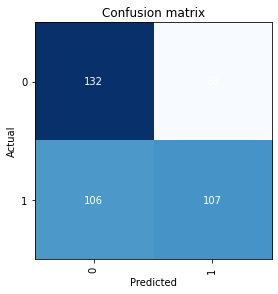

In [ ]:
interp = ClassificationInterpretation.from_learner(learn)
interp.plot_confusion_matrix()

In [ ]:
interp.top_losses()


torch.return_types.topk(...)

In [ ]:
interp.most_confused()


[(1, 0, 106), (0, 1, 68)]

In [ ]:

import matplotlib.cm as cm

txt_ci = TextClassificationInterpretation.from_learner(learn)
test_text = "Urinary frequency.Spasm of muscle.Urinary tract infection, site not specified.Viral pneumonia, unspecified.Sprain of other specified sites of elbow and forearm.Need for prophylactic vaccination and inoculation against influenza.Routine general medical examination at a health care facility.Unspecified allergic alveolitis and pneumonitis.Enlargement of lymph nodes.Abdominal pain, other specified site; multiple sites.Acute sinusitis                                                                                                                                                                                                                                                .Pleurisy                                                                                                                                                                                                                                                       .Lumbago"
txt_ci.show_intrinsic_attention(test_text,cmap=cm.Purples)

/usr/local/lib/python3.6/dist-packages/fastai/text/learner.py:226: UserWarning: masked_fill_ received a mask with dtype torch.uint8, this behavior is now deprecated,please use a mask with dtype torch.bool instead. (Triggered internally at  /pytorch/aten/src/ATen/native/TensorAdvancedIndexing.cpp:650.)
  avg_pool = output.masked_fill(mask[:, :, None], 0).mean(dim=1)
/usr/local/lib/python3.6/dist-packages/fastai/text/learner.py:228: UserWarning: masked_fill_ received a mask with dtype torch.uint8, this behavior is now deprecated,please use a mask with dtype torch.bool instead. (Triggered internally at  /pytorch/aten/src/ATen/native/TensorAdvancedIndexing.cpp:650.)
  max_pool = output.masked_fill(mask[:,:,None], -float('inf')).max(dim=1)[0]
/usr/local/lib/python3.6/dist-packages/torch/autograd/__init__.py:132: UserWarning: masked_fill_ received a mask with dtype torch.uint8, this behavior is now deprecated,please use a mask with dtype torch.bool instead. (Triggered internally at  /pytorch

In [ ]:
test_text = "Urinary frequency.Spasm of muscle.Urinary tract infection, site not specified.Viral pneumonia, unspecified.Sprain of other specified sites of elbow and forearm.Need for prophylactic vaccination and inoculation against influenza.Routine general medical examination at a health care facility.Unspecified allergic alveolitis and pneumonitis.Enlargement of lymph nodes.Abdominal pain, other specified site; multiple sites.Acute sinusitis                                                                                                                         .Pleurisy                                                                                                                                                                            .Lumbago"
txt_ci.show_intrinsic_attention(test_text,cmap=cm.Purples)

/usr/local/lib/python3.6/dist-packages/fastai/text/learner.py:226: UserWarning: masked_fill_ received a mask with dtype torch.uint8, this behavior is now deprecated,please use a mask with dtype torch.bool instead. (Triggered internally at  /pytorch/aten/src/ATen/native/TensorAdvancedIndexing.cpp:650.)
  avg_pool = output.masked_fill(mask[:, :, None], 0).mean(dim=1)
/usr/local/lib/python3.6/dist-packages/fastai/text/learner.py:228: UserWarning: masked_fill_ received a mask with dtype torch.uint8, this behavior is now deprecated,please use a mask with dtype torch.bool instead. (Triggered internally at  /pytorch/aten/src/ATen/native/TensorAdvancedIndexing.cpp:650.)
  max_pool = output.masked_fill(mask[:,:,None], -float('inf')).max(dim=1)[0]
/usr/local/lib/python3.6/dist-packages/torch/autograd/__init__.py:132: UserWarning: masked_fill_ received a mask with dtype torch.uint8, this behavior is now deprecated,please use a mask with dtype torch.bool instead. (Triggered internally at  /pytorch

In [ ]:
test_text = "Coronary atherosclerosis of native coronary artery.Hypertrophy (benign) of prostate without urinary obstruction and other lower urinary tract symptoms (LUTS).Chronic hepatitis C without mention of hepatic coma.Benign essential hypertension.Other chest pain.Pure hypercholesterolemia.Human immunodeficiency virus (HIV) disease.Abnormality of gaitGlobulin.Albumin/Globulin.Bilirubin.Chloride.Potassium.Protein "
txt_ci.show_intrinsic_attention(test_text,cmap=cm.Purples)

/usr/local/lib/python3.6/dist-packages/fastai/text/learner.py:226: UserWarning: masked_fill_ received a mask with dtype torch.uint8, this behavior is now deprecated,please use a mask with dtype torch.bool instead. (Triggered internally at  /pytorch/aten/src/ATen/native/TensorAdvancedIndexing.cpp:650.)
  avg_pool = output.masked_fill(mask[:, :, None], 0).mean(dim=1)
/usr/local/lib/python3.6/dist-packages/fastai/text/learner.py:228: UserWarning: masked_fill_ received a mask with dtype torch.uint8, this behavior is now deprecated,please use a mask with dtype torch.bool instead. (Triggered internally at  /pytorch/aten/src/ATen/native/TensorAdvancedIndexing.cpp:650.)
  max_pool = output.masked_fill(mask[:,:,None], -float('inf')).max(dim=1)[0]
/usr/local/lib/python3.6/dist-packages/torch/autograd/__init__.py:132: UserWarning: masked_fill_ received a mask with dtype torch.uint8, this behavior is now deprecated,please use a mask with dtype torch.bool instead. (Triggered internally at  /pytorch

In [ ]:
test_text = "Postnasal drip.Other acute sinusitis"
txt_ci.show_intrinsic_attention(test_text,cmap=cm.Purples)

/usr/local/lib/python3.6/dist-packages/fastai/text/learner.py:226: UserWarning: masked_fill_ received a mask with dtype torch.uint8, this behavior is now deprecated,please use a mask with dtype torch.bool instead. (Triggered internally at  /pytorch/aten/src/ATen/native/TensorAdvancedIndexing.cpp:650.)
  avg_pool = output.masked_fill(mask[:, :, None], 0).mean(dim=1)
/usr/local/lib/python3.6/dist-packages/fastai/text/learner.py:228: UserWarning: masked_fill_ received a mask with dtype torch.uint8, this behavior is now deprecated,please use a mask with dtype torch.bool instead. (Triggered internally at  /pytorch/aten/src/ATen/native/TensorAdvancedIndexing.cpp:650.)
  max_pool = output.masked_fill(mask[:,:,None], -float('inf')).max(dim=1)[0]
/usr/local/lib/python3.6/dist-packages/torch/autograd/__init__.py:132: UserWarning: masked_fill_ received a mask with dtype torch.uint8, this behavior is now deprecated,please use a mask with dtype torch.bool instead. (Triggered internally at  /pytorch

In [ ]:
txt_ci.show_top_losses(50)


Text,Prediction,Actual,Loss,Probability
"xxbos xxmaj abnormal weight gain . xxmaj depressive disorder , xxunk . xxmaj influenza xxunk essential hypertension . xxmaj family history of ischemic heart disease . xxmaj attention or concentration deficit",1,0,2.55,0.08
xxbos xxmaj acute frontal sinusitis . xxmaj acute nasopharyngitis [ common xxunk maxillary sinusitis . xxmaj mixed hyperlipidemia,0,1,2.40,0.09
xxbos xxmaj acute upper respiratory infections of unspecified site . xxmaj allergic rhinitis xxunk sinusitis xxunk suppurative otitis media without spontaneous rupture of ear drum,0,1,2.15,0.12
"xxbos xxmaj insomnia with sleep apnea , unspecified . xxmaj screening for depression . xxmaj dysmetabolic syndrome xxunk deficiency anemia , unspecified . xxmaj mixed hyperlipidemia . xxmaj generalized anxiety disorder . xxmaj screening for alcoholism . xxmaj personal history of cervical dysplasia . xxmaj counseling on substance use and abuse . xxmaj family history of ischemic heart disease . xxmaj unspecified vitamin d deficiency . xxmaj migraine without aura",1,0,1.73,0.18
"xxbos xxmaj need for prophylactic vaccination and inoculation against influenza . xxmaj benign essential hypertension . xxmaj polyneuropathy in other diseases classified elsewhere . xxmaj esophageal reflux . xxmaj other malaise and fatigue . xxmaj disturbance of skin sensation . xxmaj migraine without aura , without mention of intractable migraine without mention of status migrainosus . xxmaj mixed hyperlipidemia . xxmaj other atopic dermatitis and related conditions . xxmaj acute",1,0,1.70,0.18
"xxbos xxmaj constipation , unspecified . xxmaj anxiety state , unspecified . xxmaj symptomatic menopausal or female climacteric states . xxmaj acute maxillary sinusitis . xxmaj unspecified disorder of kidney and ureter . xxmaj allergic rhinitis , cause unspecified . xxmaj depressive disorder , xxunk for long - term ( current ) use of anticoagulants . xxmaj anxiety state , unspecified . xxmaj body xxmaj mass xxmaj index 33.0 -",1,0,1.67,0.19
"xxbos xxmaj acute cholecystitis . xxmaj diverticulosis of colon ( without mention of xxunk c - reactive protein ( xxunk hypercholesterolemia . xxmaj flatulence , eructation , and gas pain",0,1,1.65,0.19
xxbos xxmaj encounter for surveillance of contraceptive pill,0,1,1.65,0.19
"xxbos xxmaj routine general medical examination at a health care facility . xxmaj nonspecific abnormal xxmaj papanicolaou smear of cervix . xxmaj general medical exam xxunk pain . xxmaj unspecified viral infection in conditions classified elsewhere and of unspecified site . xxmaj mixed hyperlipidemia . xxmaj lupus erythematosus . xxmaj premenopausal menorrhagia . xxmaj esophageal reflux . xxmaj tobacco use disorder . xxmaj urinary tract infection , site not specified",1,0,1.62,0.20
"xxbos xxmaj reflux esophagitis . xxmaj unspecified essential hypertension . xxmaj asthma , unspecified type , without mention of status asthmaticus . xxmaj unspecified chest pain . xxmaj viral hepatitis b with hepatic coma , acute or unspecified , without mention of hepatitis delta . xxmaj actinic keratosis . xxmaj unspecified sleep apnea . xxmaj myalgia and myositis , unspecified . xxmaj infective otitis externa , unspecified . xxmaj nonspecific",1,0,1.61,0.20


In [ ]:
learn.predict("Other abscess of vulva.Symptomatic menopausal or female climacteric states.Acute sinusitis                                                                                                                                                                                                                                                .Insect bite, nonvenomous, of other, multiple, and unspecified sites, without mention of infection.Otalgia, unspecified.Other atopic dermatitis and related conditions.Pain in joint involving upper arm")

(Category tensor(1), tensor(1), tensor([0.3354, 0.6646]))

In [ ]:
!pwd

In [ ]:
!ls